# Training Model: Cnn + wavelets transform

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install obspy

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from obspy import read
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [5]:
base_path = '/content/gdrive/MyDrive'

train_augmented_data_path = f'{base_path}/Notebooks/SeismicWaves/training_augmented/augmented'
train_data_path = f'{base_path}/Notebooks/SeismicWaves/training_augmented/train'
val_data_path = f'{base_path}/Notebooks/SeismicWaves/training_augmented/val'
test_data_path = f'{base_path}/Notebooks/SeismicWaves/training_augmented/testing'
features_path = f'{base_path}/Notebooks/SeismicWaves/procesing'

In [3]:

def analyze_signal_lengths(data_path):
    """
    Analiza las longitudes de las señales en un directorio.

    Args:
        data_path: Ruta al directorio con archivos MSEED

    Returns:
        dict: Estadísticas de longitud de señales
    """
    lengths = []
    files_df = pd.read_csv(os.path.join(data_path, "feature_files.csv"))

    print(f"Analizando señales en {data_path}...")
    for file in tqdm(files_df["file"]):
        file_path = os.path.join(data_path, file)
        try:
            st = read(file_path)
            signal_length = len(st[0].data)
            lengths.append(signal_length)
        except Exception as e:
            print(f"Error procesando {file}: {str(e)}")
            continue

    stats = {
        "min_length": min(lengths),
        "max_length": max(lengths),
        "mean_length": np.mean(lengths),
        "median_length": np.median(lengths),
        "std_length": np.std(lengths),
        "p95_length": np.percentile(lengths, 95),
        "num_signals": len(lengths),
    }

    return stats, lengths



Analizando señales en /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/train...


100%|██████████| 1663/1663 [10:34<00:00,  2.62it/s]


Analizando señales en /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/val...


100%|██████████| 317/317 [00:05<00:00, 60.36it/s]


Analizando señales en /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/testing...


100%|██████████| 496/496 [00:08<00:00, 57.02it/s]



Estadísticas de longitud de señales:

Conjunto de entrenamiento:
min_length: 2981.00
max_length: 23701.00
mean_length: 7272.59
median_length: 7201.00
std_length: 798.00
p95_length: 8401.00
num_signals: 1663.00

Conjunto de validación:
min_length: 3963.00
max_length: 10001.00
mean_length: 7334.65
median_length: 7201.00
std_length: 698.32
p95_length: 8601.00
num_signals: 317.00

Conjunto de prueba:
min_length: 3600.00
max_length: 18201.00
mean_length: 7288.48
median_length: 7201.00
std_length: 821.88
p95_length: 8401.00
num_signals: 496.00


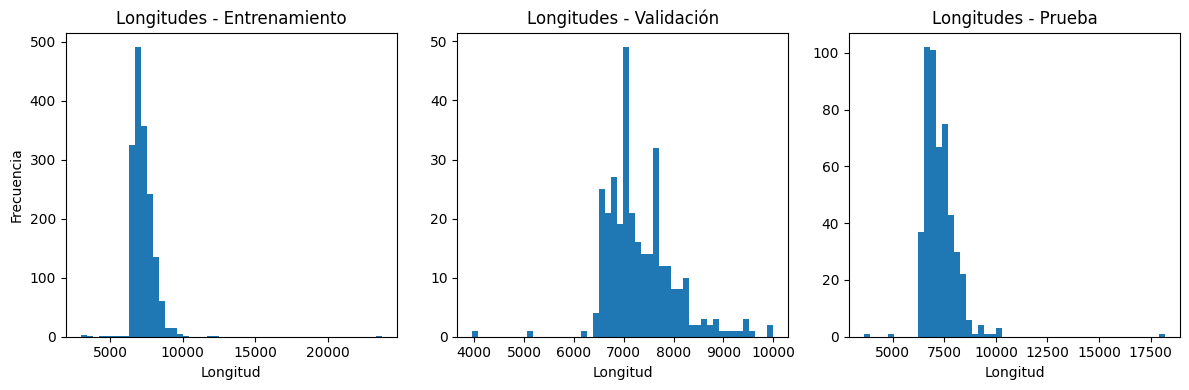

In [6]:

# Analizar cada conjunto de datos
train_stats, train_lengths = analyze_signal_lengths(train_data_path)
val_stats, val_lengths = analyze_signal_lengths(val_data_path)
test_stats, test_lengths = analyze_signal_lengths(test_data_path)

# Mostrar resultados
print("\nEstadísticas de longitud de señales:")
print("\nConjunto de entrenamiento:")
for key, value in train_stats.items():
    print(f"{key}: {value:.2f}")

print("\nConjunto de validación:")
for key, value in val_stats.items():
    print(f"{key}: {value:.2f}")

print("\nConjunto de prueba:")
for key, value in test_stats.items():
    print(f"{key}: {value:.2f}")

# Visualizar distribución de longitudes
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.hist(train_lengths, bins=50)
plt.title("Longitudes - Entrenamiento")
plt.xlabel("Longitud")
plt.ylabel("Frecuencia")

plt.subplot(132)
plt.hist(val_lengths, bins=50)
plt.title("Longitudes - Validación")
plt.xlabel("Longitud")

plt.subplot(133)
plt.hist(test_lengths, bins=50)
plt.title("Longitudes - Prueba")
plt.xlabel("Longitud")

plt.tight_layout()
plt.show()

In [21]:

def pad_or_trim(signal, target_length=8000):
    if len(signal) > target_length:
        return signal[:target_length]
    elif len(signal) < target_length:
        pad_width = target_length - len(signal)
        return np.pad(signal, (0, pad_width), mode='constant')
    return signal

# ------------------- Funciones de Carga -------------------
def load_data(data_path):
    # Cargar señales crudas
    raw_signals = []
    files_df = pd.read_csv(os.path.join(data_path, 'feature_files.csv'))
    print(f'Cargando señales desde {data_path}...')
    for file in tqdm(files_df['file']):
        file_path = os.path.join(data_path, file)
        st = read(file_path)
        signal = st[0].data
        signal = pad_or_trim(signal, target_length=8000)
        raw_signals.append(signal)

    X_raw = np.array(raw_signals)
    X_raw = X_raw.reshape(X_raw.shape[0], -1, 1)  # Añadir dimensión para CNN

    # Cargar características wavelets
    X_wavelets = np.load(os.path.join(data_path, 'wavelet_features.npy'))

    # Cargar tiempos de llegada
    y = np.load(os.path.join(data_path, 'arrival_times.npy'))

    return X_raw, X_wavelets, y, files_df

# ------------------- Carga de Datos -------------------
X_raw_train, X_wavelets_train, y_train, train_files = load_data(train_augmented_data_path)
X_raw_val, X_wavelets_val, y_val, val_files = load_data(val_data_path)
X_raw_test, X_wavelets_test, y_test, test_files = load_data(test_data_path)

print('Formas:')
print(f'Entrenamiento señales crudas: {X_raw_train.shape}')
print(f'Validación señales crudas: {X_raw_val.shape}')
print(f'Prueba señales crudas: {X_raw_test.shape}')

Cargando señales desde /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/augmented...


100%|██████████| 4989/4989 [01:27<00:00, 56.96it/s]


Cargando señales desde /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/val...


100%|██████████| 317/317 [00:05<00:00, 57.90it/s]


Cargando señales desde /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/testing...


100%|██████████| 496/496 [00:10<00:00, 47.05it/s]


Formas:
Entrenamiento señales crudas: (4989, 8000, 1)
Validación señales crudas: (317, 8000, 1)
Prueba señales crudas: (496, 8000, 1)


In [22]:
# ------------------- Creación del Modelo -------------------
def create_model(input_shape_raw, input_shape_wavelets):
    raw_input = tf.keras.layers.Input(shape=input_shape_raw)
    x1 = tf.keras.layers.BatchNormalization()(raw_input)
    x1 = tf.keras.layers.Conv1D(32, 5, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.MaxPooling1D(2)(x1)
    x1 = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.MaxPooling1D(2)(x1)
    x1 = tf.keras.layers.Conv1D(128, 5, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)

    wavelet_input = tf.keras.layers.Input(shape=input_shape_wavelets)
    x2 = tf.keras.layers.BatchNormalization()(wavelet_input)
    x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Dropout(0.3)(x2)

    combined = tf.keras.layers.concatenate([x1, x2])

    x = tf.keras.layers.Dense(256, activation='relu')(combined)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    output = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[raw_input, wavelet_input], outputs=output)
    return model

input_shape_raw = (8000, 1)
input_shape_wavelets = (X_wavelets_train.shape[1],)

model = create_model(input_shape_raw, input_shape_wavelets)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 8000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8000, 1)   │          4 │ input_layer_4[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 8000, 32)  │        192 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8000, 32)  │        128 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 4000, 32)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 4000, 64)  │     10,304 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4000, 64)  │        256 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 2000, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60)        │        240 │ input_layer_5[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 2000, 128) │     41,088 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │      7,808 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 128) │        512 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │     65,792 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_9[0][0]   

 Total params: 161,397 (630.46 KB)

 Trainable params: 159,803 (624.23 KB)

 Non-trainable params: 1,594 (6.23 KB)

In [23]:
# ------------------- Callbacks -------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=5, min_lr=1e-6, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(filepath='augmeted_model.keras', monitor='val_mae', save_best_only=True, mode='min')
]

# ------------------- Entrenamiento -------------------
history = model.fit(
    [X_raw_train, X_wavelets_train],
    y_train,
    validation_data=([X_raw_val, X_wavelets_val], y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 26s 191ms/step - loss: 923.0400 - mae: 29.9839 - mse: 923.0400 - val_loss: 802.8702 - val_mae: 28.1140 - val_mse: 802.8702 - learning_rate: 0.0010
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - loss: 804.4974 - mae: 27.9492 - mse: 804.4974 - val_loss: 623.6250 - val_mae: 24.7564 - val_mse: 623.6250 - learning_rate: 0.0010
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 582.5784 - mae: 23.5666 - mse: 582.5784 - val_loss: 344.5493 - val_mae: 18.3289 - val_mse: 344.5493 - learning_rate: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 304.4127 - mae: 16.6350 - mse: 304.4127 - val_loss: 116.9643 - val_mae: 10.5617 - val_mse: 116.9644 - learning_rate: 0.0010
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 115.9669 - mae: 9.6212 - mse: 115.9669 - val_loss: 34.8180 - val_mae: 5.2260 - val_mse: 34.8180 - learning_rate: 0.0010
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 45.2986 - mae: 5.31

In [24]:
# ------------------- Evaluación -------------------
print('Realizando predicciones en conjunto de prueba...')
y_pred = model.predict([X_raw_test, X_wavelets_test])

# Guardar resultados
results_df = pd.DataFrame({
    'file': test_files['file'],
    'real_time': y_test,
    'predicted_time': y_pred.flatten(),
    'error': y_pred.flatten() - y_test
})
results_df['abs_error'] = np.abs(results_df['error'])
results_df = results_df.sort_values('abs_error', ascending=False)

results_df.to_csv(os.path.join(features_path, 'model_evaluation_results.csv'), index=False)


Realizando predicciones en conjunto de prueba...
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [25]:
# ------------------- Métricas Finales -------------------
print('\nMétricas de rendimiento en conjunto de prueba:')
mae = np.mean(np.abs(results_df['error']))
rmse = np.sqrt(np.mean(results_df['error']**2))
max_error = np.max(results_df['abs_error'])

print(f'MAE: {mae:.4f} segundos')
print(f'RMSE: {rmse:.4f} segundos')
print(f'Máximo error: {max_error:.4f} segundos')


Métricas de rendimiento en conjunto de prueba:
MAE: 1.0369 segundos
RMSE: 2.8667 segundos
Máximo error: 30.0965 segundos


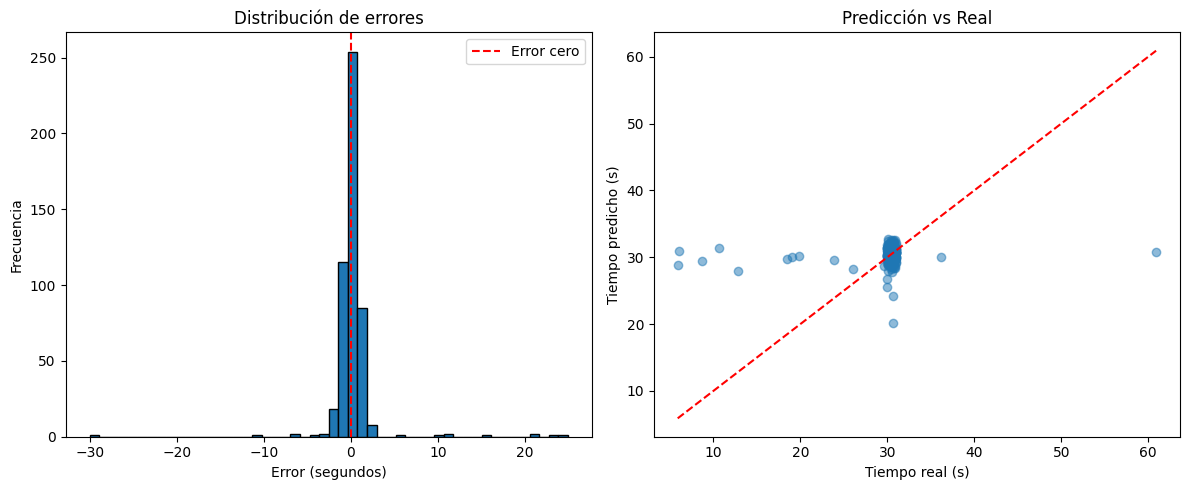


Estadísticas de errores:
Error medio: 0.2324 segundos
Desviación estándar: 2.8572 segundos
Mediana del error: 0.1238 segundos
Error dentro de ±0.5s: 48.4%
Error dentro de ±1.0s: 77.0%


In [26]:
# ------------------- Visualización -------------------
errors = y_pred.flatten() - y_test

plt.figure(figsize=(12, 5))

# Histograma de errores
plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Distribución de errores')
plt.xlabel('Error (segundos)')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='r', linestyle='--', label='Error cero')
plt.legend()

# Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred.flatten(), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Tiempo real (s)')
plt.ylabel('Tiempo predicho (s)')
plt.title('Predicción vs Real')

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print('\nEstadísticas de errores:')
print(f'Error medio: {np.mean(errors):.4f} segundos')
print(f'Desviación estándar: {np.std(errors):.4f} segundos')
print(f'Mediana del error: {np.median(errors):.4f} segundos')
print(f'Error dentro de ±0.5s: {100*np.mean(np.abs(errors) < 0.5):.1f}%')
print(f'Error dentro de ±1.0s: {100*np.mean(np.abs(errors) < 1.0):.1f}%')

In [27]:
# ------------------- Carga de Datos -------------------
X_raw_train, X_wavelets_train, y_train, train_files = load_data(train_data_path)
X_raw_val, X_wavelets_val, y_val, val_files = load_data(val_data_path)
X_raw_test, X_wavelets_test, y_test, test_files = load_data(test_data_path)

print('Formas:')
print(f'Entrenamiento señales crudas: {X_raw_train.shape}')
print(f'Validación señales crudas: {X_raw_val.shape}')
print(f'Prueba señales crudas: {X_raw_test.shape}')

# ------------------- Creación del Modelo -------------------
def create_model(input_shape_raw, input_shape_wavelets):
    raw_input = tf.keras.layers.Input(shape=input_shape_raw)
    x1 = tf.keras.layers.BatchNormalization()(raw_input)
    x1 = tf.keras.layers.Conv1D(32, 5, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.MaxPooling1D(2)(x1)
    x1 = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.MaxPooling1D(2)(x1)
    x1 = tf.keras.layers.Conv1D(128, 5, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)

    wavelet_input = tf.keras.layers.Input(shape=input_shape_wavelets)
    x2 = tf.keras.layers.BatchNormalization()(wavelet_input)
    x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Dropout(0.3)(x2)

    combined = tf.keras.layers.concatenate([x1, x2])

    x = tf.keras.layers.Dense(256, activation='relu')(combined)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    output = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[raw_input, wavelet_input], outputs=output)
    return model

input_shape_raw = (8000, 1)
input_shape_wavelets = (X_wavelets_train.shape[1],)

model = create_model(input_shape_raw, input_shape_wavelets)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
model.summary()

# ------------------- Callbacks -------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=5, min_lr=1e-6, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(filepath='normal_data.keras', monitor='val_mae', save_best_only=True, mode='min')
]

# ------------------- Entrenamiento -------------------
history = model.fit(
    [X_raw_train, X_wavelets_train],
    y_train,
    validation_data=([X_raw_val, X_wavelets_val], y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Cargando señales desde /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/train...


100%|██████████| 1663/1663 [00:29<00:00, 56.51it/s]


Cargando señales desde /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/val...


100%|██████████| 317/317 [00:05<00:00, 53.78it/s]


Cargando señales desde /content/gdrive/MyDrive/Notebooks/SeismicWaves/training_augmented/testing...


100%|██████████| 496/496 [00:08<00:00, 58.27it/s]


Formas:
Entrenamiento señales crudas: (1663, 8000, 1)
Validación señales crudas: (317, 8000, 1)
Prueba señales crudas: (496, 8000, 1)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 8000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8000, 1)   │          4 │ input_layer_6[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 8000, 32)  │        192 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8000, 32)  │        128 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 4000, 32)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 4000, 64)  │     10,304 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4000, 64)  │        256 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 2000, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60)        │        240 │ input_layer_7[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 2000, 128) │     41,088 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │      7,808 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2000, 128) │        512 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │     65,792 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_13[0][0]  

 Total params: 161,397 (630.46 KB)

 Trainable params: 159,803 (624.23 KB)

 Non-trainable params: 1,594 (6.23 KB)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 447ms/step - loss: 919.9874 - mae: 30.1674 - mse: 919.9874 - val_loss: 771.3480 - val_mae: 27.5491 - val_mse: 771.3481 - learning_rate: 0.0010
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 889.1205 - mae: 29.6471 - mse: 889.1205 - val_loss: 784.1013 - val_mae: 27.7763 - val_mse: 784.1013 - learning_rate: 0.0010
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 865.2930 - mae: 29.2391 - mse: 865.2930 - val_loss: 777.0379 - val_mae: 27.6485 - val_mse: 777.0379 - learning_rate: 0.0010
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 823.1367 - mae: 28.5216 - mse: 823.1367 - val_loss: 755.8062 - val_mae: 27.2625 - val_mse: 755.8062 - learning_rate: 0.0010
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 768.5917 - mae: 27.5601 - mse: 768.5917 - val_loss: 710.9633 - val_mae: 26.4373 - val_mse: 710.9633 - learning_rate: 0.0010
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 699.8344 - mae: 26

In [28]:
# ------------------- Evaluación -------------------
print('Realizando predicciones en conjunto de prueba...')
y_pred = model.predict([X_raw_test, X_wavelets_test])

# Guardar resultados
results_df = pd.DataFrame({
    'file': test_files['file'],
    'real_time': y_test,
    'predicted_time': y_pred.flatten(),
    'error': y_pred.flatten() - y_test
})
results_df['abs_error'] = np.abs(results_df['error'])
results_df = results_df.sort_values('abs_error', ascending=False)

results_df.to_csv(os.path.join(features_path, 'model_evaluation_results.csv'), index=False)


Realizando predicciones en conjunto de prueba...
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [29]:
# ------------------- Métricas Finales -------------------
print('\nMétricas de rendimiento en conjunto de prueba:')
mae = np.mean(np.abs(results_df['error']))
rmse = np.sqrt(np.mean(results_df['error']**2))
max_error = np.max(results_df['abs_error'])

print(f'MAE: {mae:.4f} segundos')
print(f'RMSE: {rmse:.4f} segundos')
print(f'Máximo error: {max_error:.4f} segundos')


Métricas de rendimiento en conjunto de prueba:
MAE: 0.9401 segundos
RMSE: 2.8205 segundos
Máximo error: 30.8757 segundos


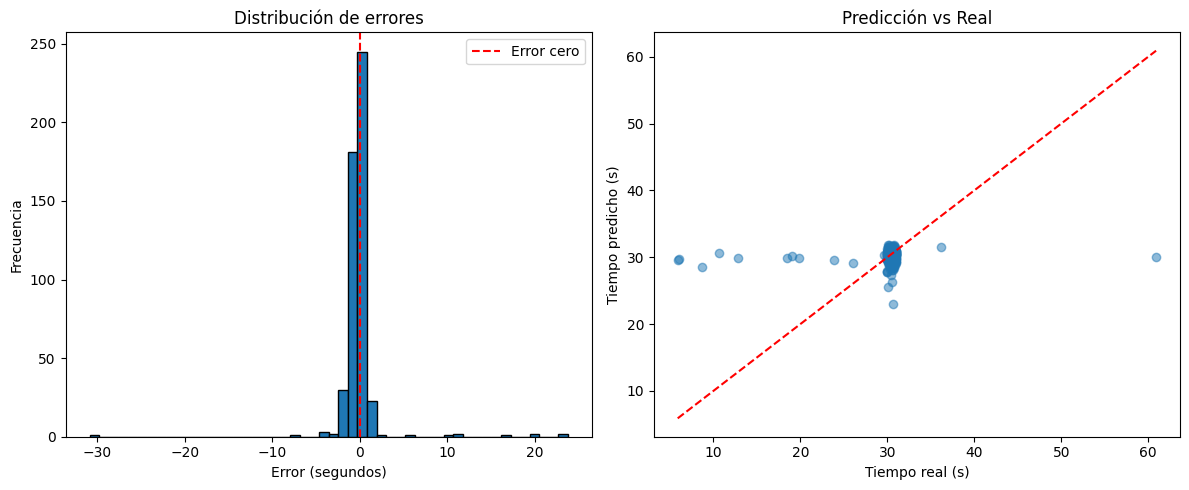


Estadísticas de errores:
Error medio: -0.0221 segundos
Desviación estándar: 2.8204 segundos
Mediana del error: -0.1777 segundos
Error dentro de ±0.5s: 51.6%
Error dentro de ±1.0s: 84.3%


In [30]:
# ------------------- Visualización -------------------
errors = y_pred.flatten() - y_test

plt.figure(figsize=(12, 5))

# Histograma de errores
plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Distribución de errores')
plt.xlabel('Error (segundos)')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='r', linestyle='--', label='Error cero')
plt.legend()

# Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred.flatten(), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Tiempo real (s)')
plt.ylabel('Tiempo predicho (s)')
plt.title('Predicción vs Real')

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print('\nEstadísticas de errores:')
print(f'Error medio: {np.mean(errors):.4f} segundos')
print(f'Desviación estándar: {np.std(errors):.4f} segundos')
print(f'Mediana del error: {np.median(errors):.4f} segundos')
print(f'Error dentro de ±0.5s: {100*np.mean(np.abs(errors) < 0.5):.1f}%')
print(f'Error dentro de ±1.0s: {100*np.mean(np.abs(errors) < 1.0):.1f}%')